In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import numpy as np
import spacy

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load spaCy's English language model for lemmatization
# python -m spacy download en_core_web_sm
spacy_nlp = spacy.load("en_core_web_sm")

# Consumer Complaints

Forschungsfrage: Wie kann ein automatisches Textklassifikationsmodell entwickelt werden, das Kundenbeschwerden basierend auf ihrem Inhalt den richtigen Produktkategorien zuordnet?

## Pre-Processing

Einlesen der Daten und Entfernen der Indexspalte.

In [3]:
# Load data
data = pd.read_csv('data/complaints_processed.csv')
# Delete first row (index)
data = data.drop(data.columns[0], axis=1)

data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


Überprüfung auf fehlende Werte. Da nur 10 von 160k der Narratives fehlen, werden sie einfach entfernt.

In [4]:
# Check the number of rows
print("Number of rows: ", data.shape[0])
# Check for missing values
print("Number of missing values: ", data.isnull().sum().sum())
data = data.dropna() #drop missing values
# Check number of rows after dropping missing values
print("Number of rows after dropping missing values ", data.shape[0])

Number of rows:  162421
Number of missing values:  10
Number of rows after dropping missing values  162411


Überprüfen, ob HTML-Tags, Satzzeichen und Zahlen vorhanden sind und ob Inhalte in Upper Case geschrieben sind. Da dies nicht zutrifft, werden keine Transformationen in diesem Sinne vorgenommen.

In [5]:
print("Number of rows with html tags:", data['narrative'].str.contains('<.*?>', regex=True).sum())
print("Number of rows with punctuation:", data['narrative'].str.contains('[^\w\s]', regex=True).sum())
print("Number of rows with numbers:", data['narrative'].str.contains('\d', regex=True).sum())
print("Number of rows with uppercase:", data['narrative'].str.contains('[A-Z]', regex=True).sum())

Number of rows with html tags: 0
Number of rows with punctuation: 0
Number of rows with numbers: 0
Number of rows with uppercase: 0


Erstellen einer neuen Spalte, in der Stoppwörter aus narrative entfernt werden. Entfernen der Zeilen mit weniger als 4 Wörtern in der neuen Spalte, da sie kaum aussagekräftig sind und nur einen Bruchteil der Gesamtdaten ausmachen

In [6]:
# Create a columns for the cleaned narrative
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

data['narrative_prep'] = data['narrative'].apply(lambda text: remove_stopwords(text))

In [7]:
# Show number of that are empty after removing stop words
print("Number of rows with empty narratives after removing stop words:", data[data['narrative_prep'] == ''].shape[0])
# Show number of rows with narratives that have less than 4 words
print("Number of rows with narratives that have less than 4 words:", data[data['narrative_prep'].str.split().apply(len) < 4].shape[0])

# Remove rows with narratives that have less than 4 words
data = data[data['narrative_prep'].str.split().apply(len) >= 4]

# Show number of rows after removing rows
print("Number of rows after removing rows", data.shape[0])

Number of rows with empty narratives after removing stop words: 7
Number of rows with narratives that have less than 4 words: 1756
Number of rows after removing rows 160655


In [ ]:
#### KEINE GEDULD GEHABT LAUFEN ZU LASSEN ####
# Process large text as a stream via `nlp.pipe()` and iterate over the results, extracting lemmas
lemma_text_list = []
for doc in spacy_nlp.pipe(data["narrative_prep"]):
    lemma_text_list.append(" ".join(token.lemma_ for token in doc))
data["text_lemma"] = lemma_text_list

In [9]:
# Calculate the length of lemmatized narrative
data['narrative_prep_len'] = data['narrative_prep'].apply(lambda text: len(text.split()))

## Explorative Data Analysis

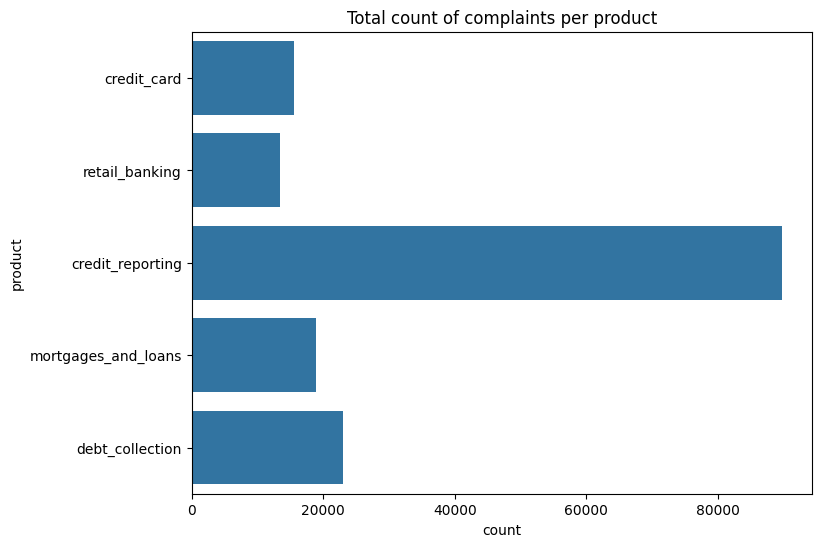

In [10]:
# Total count of complaints per product
plt.figure(figsize=(8, 6))
sns.countplot(data['product'])
plt.title('Total count of complaints per product')
plt.show()

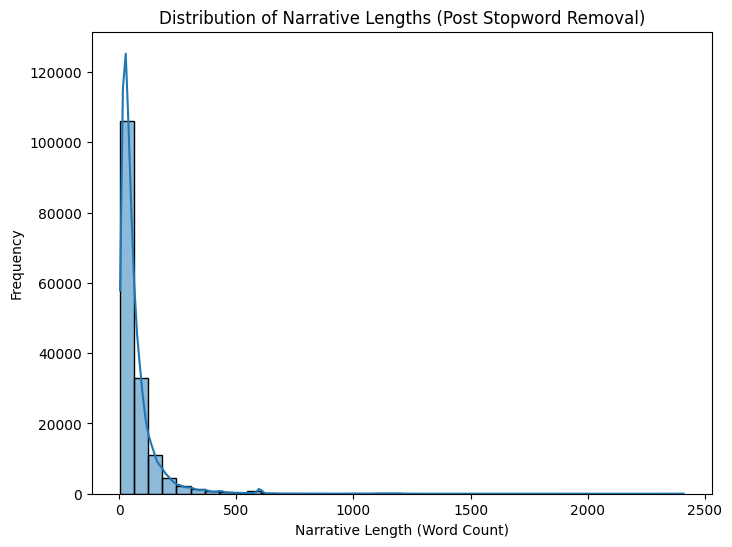

In [11]:
# Distribution of Narrative Lengths (after stopword removal)
plt.figure(figsize=(8, 6))
sns.histplot(data['narrative_prep_len'], bins=40, kde=True)
plt.title('Distribution of Narrative Lengths (Post Stopword Removal)')
plt.xlabel('Narrative Length (Word Count)')
plt.ylabel('Frequency')
plt.show()

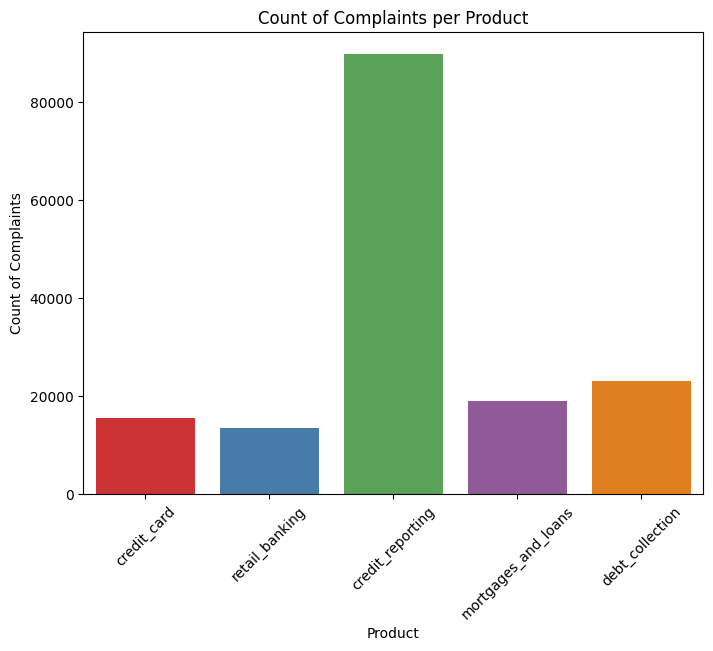

In [12]:
# Count of Complaints per Product
plt.figure(figsize=(8, 6))
sns.countplot(x='product', data=data, palette='Set1')
plt.title('Count of Complaints per Product')
plt.xlabel('Product')
plt.ylabel('Count of Complaints')
plt.xticks(rotation=45)
plt.show()

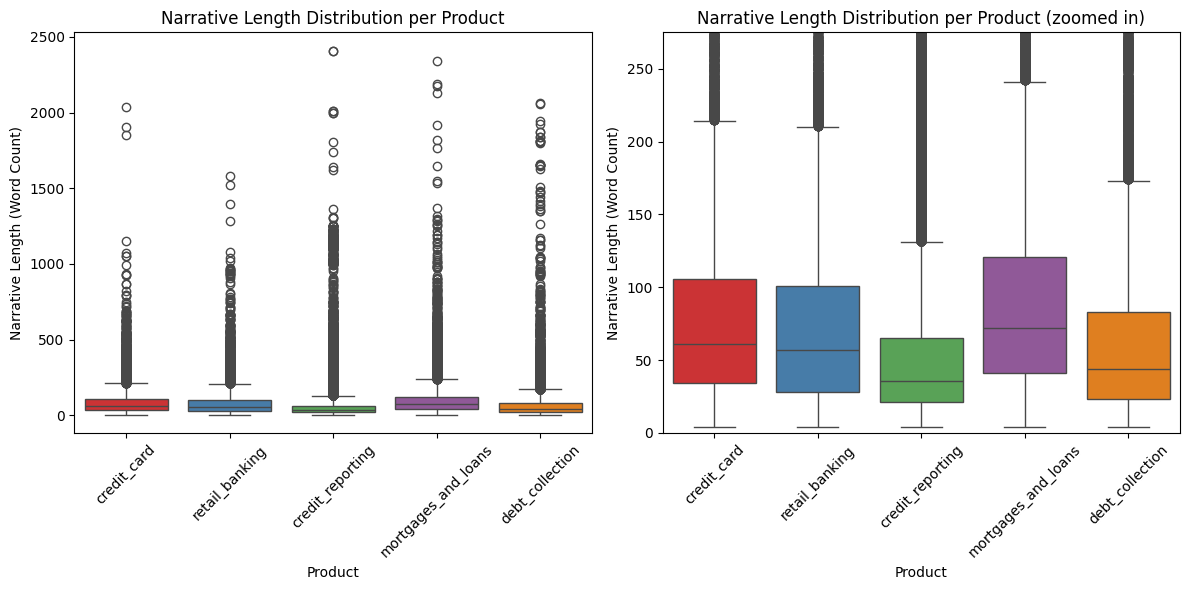

In [13]:
# Boxplot of Narrative Length per Product
def boxplot_narrative_length(data, title, ylim: int = None, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.boxplot(x='product', y='narrative_prep_len', data=data, palette='Set1', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Product')
    ax.set_ylabel('Narrative Length (Word Count)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if ylim is not None:
        ax.set_ylim(0, ylim)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first boxplot
boxplot_narrative_length(data, title='Narrative Length Distribution per Product', ax=axes[0])

# Plot the second boxplot with a y-limit of 275
boxplot_narrative_length(data, title='Narrative Length Distribution per Product (zoomed in)', ylim=275, ax=axes[1])

plt.tight_layout()
plt.show()

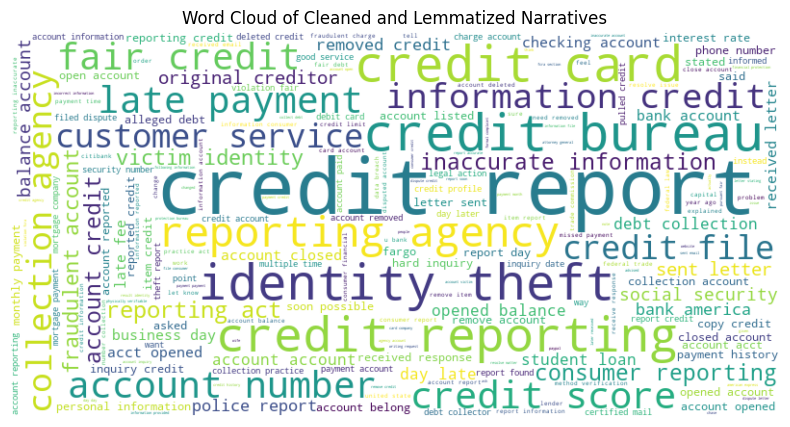

In [42]:
# Generate a word cloud from the cleaned and lemmatized narratives
all_words = ' '.join(data['narrative_prep'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Word Cloud of Cleaned and Lemmatized Narratives')
plt.show()

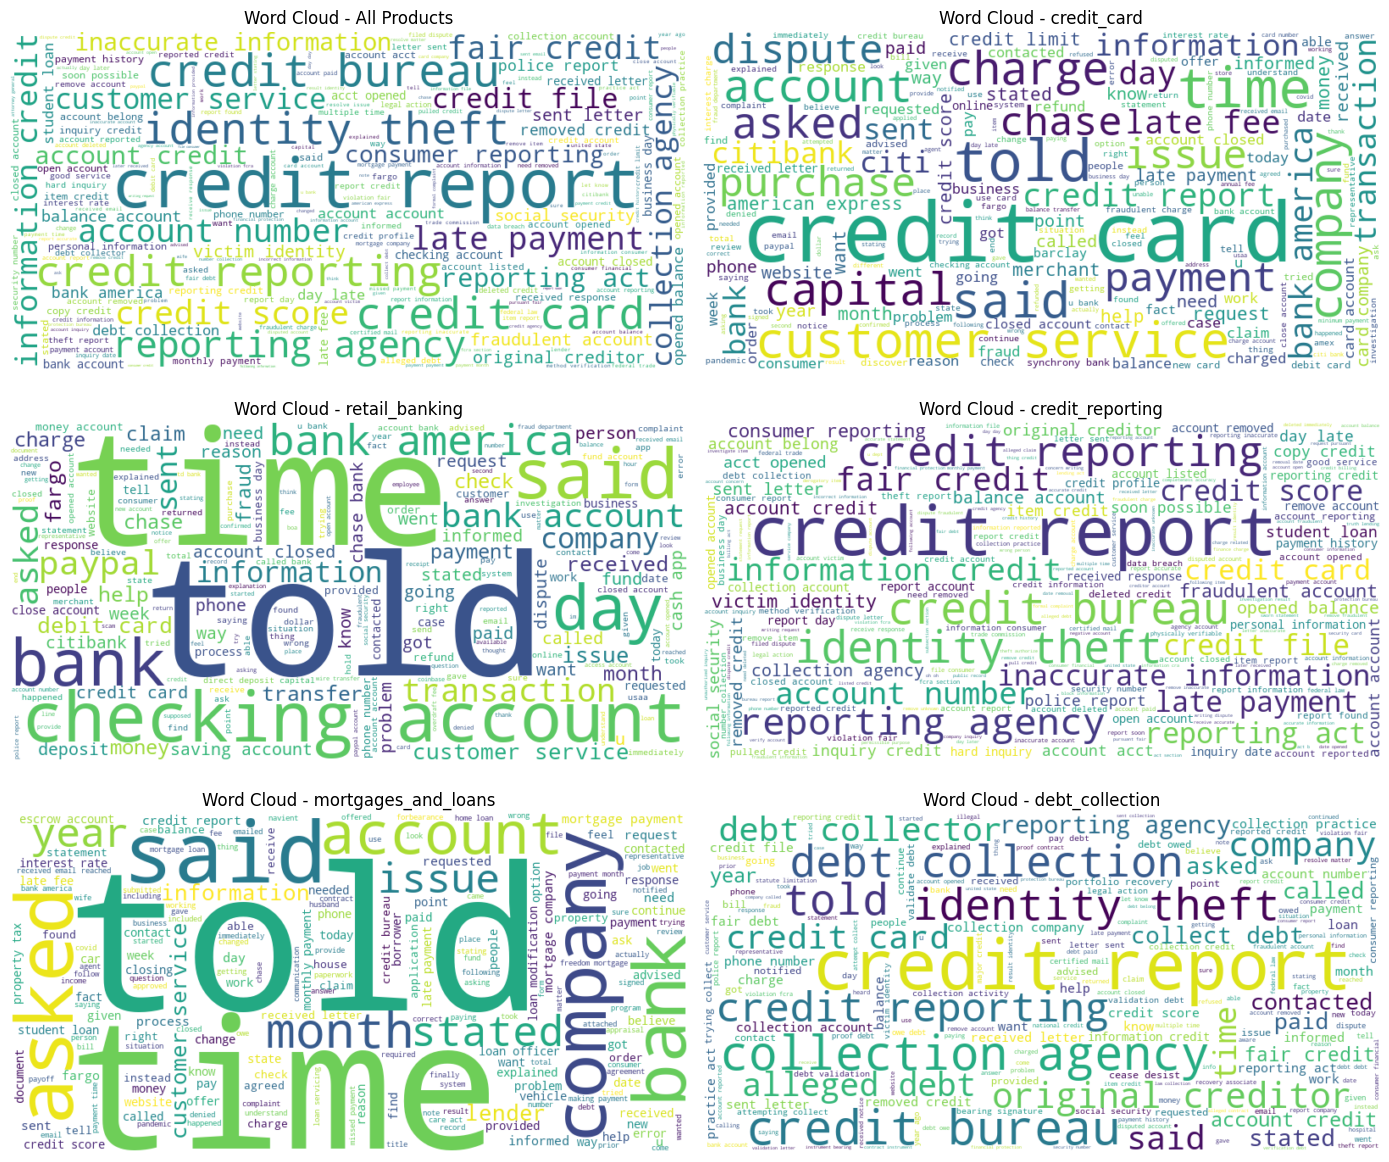

In [14]:
# Word clouds for the entire dataset and five for each product category
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Generate word cloud for the whole dataset
all_words = ' '.join(data['narrative_prep'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
axes[0, 0].imshow(wordcloud, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title('Word Cloud - All Products')

# Generate word clouds for each product category
product_categories = data['product'].unique()

for i, product in enumerate(product_categories):
    product_words = ' '.join(data[data['product'] == product]['narrative_prep'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(product_words)
    row, col = divmod(i + 1, 2)
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Word Cloud - {product}')

# Remove any unused subplots
for j in range(len(product_categories) + 1, 6):
    row, col = divmod(j, 3)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()